# CESM2-LE analysis of snowMelt and runoff
## Statistical Change Preprocess
- Reading in ensemble of data from CESM2-LE, Rodgers et al 2021 ESD https://doi.org/10.5194/esd-2021-50
- Initial file IO from Daniel Kennedy djk2120@ucar.edu, modified Will Wieder wwieder@ucar.edu with improvements from Anderson Banihirwe abanihi@ucar.edu

### Calculates annual metrics from daily data related to SWE and Runoff
- Calculates max water year SWE, the numbers of snow free days and the fraction of winter melt
- Calculates max water year runoff rates, center timing, and annual water year runoff
- focus here on characterizing summary data from daily data & writing out data to disk
- stats explored here, but full ensemble stats in Statistical Change.


In [1]:
%load_ext autoreload
%autoreload 2
import glob
import os

import cftime
import dask
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
import matplotlib.dates as mdates
import cartopy.crs as ccrs

import numba
import numpy as np
import pandas as pd
import xarray as xr
from scipy import stats
from tqdm.auto import tqdm
from distributed import wait

%matplotlib inline

In [2]:
print('xarray version '+ xr.__version__) ## was working with 17.0
print('dask version '+ dask.__version__) ## was working with 2021.02.0

xarray version 0.17.0
dask version 2021.02.0


### run this cell to check if you have LENS2 read access:

In [3]:
samplefile = ('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/lnd/proc/tseries/month_1/NBP/'+
              'b.e21.BHISTcmip6.f09_g17.LE2-1001.001.clm2.h0.NBP.199001-199912.nc')
cmd = 'stat '+samplefile
if os.system(cmd)!=0:
    print('you may not have access')
else:
    print('looks good')

looks good


### Fetch cluster

In [4]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='0:55:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })

    client = Client(cluster)
    return cluster, client

In [5]:
cluster, client = get_ClusterClient(nmem='50GB')
cluster.scale(40) # roughly 20/ 5 ensemble members
# Seem to get more woorkers easily w/ lower memory (previously 40 workers & 50 GB)

In [6]:
cluster

In [7]:
#client.restart()
#cluster.close()

### Some helpful functions:
 - run all these before proceeding to the start here area:
 - you can certainly edit these, but shouldn't need to

In [8]:
def get_members(model):
    members = []
    if model =='CESM1':
        members = [str(i).zfill(3) for i in [*(1+np.arange(35)),*(101+np.arange(7))]]
    else:
        for i,j in zip(1001+20*np.arange(10),1+np.arange(10)):
            s = 'LE2-'+str(i)+'.'+str(j).zfill(3)
            members.append(s)
        for i in [1231,1251,1281,1301]:
            for j in 1+np.arange(10):
                s = 'LE2-'+str(i)+'.'+str(j).zfill(3)
                members.append(s)
    return members

In [9]:
## Updated for new directory structure of LENS2
def file_dict(model,mem,field,hist=True,freq='monthly',component='lnd'):
    ''' returns a dictionary of filepaths keyed by year, for a given ensemble member '''
    mm = get_members(model)[mem]

    filepaths = {}
    
    if model=='CESM1':
        #detailing the directory structure
        topdir = '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/'+ \
                  component+'/proc/tseries/'
        if freq =='monthly': 
            freq = 'monthly/'
            tape = '.h0.'
        else:
            raise ValueError('ERROR: \''+freq+'\' freq not supported for '+model)
        thisdir = topdir+freq+field+'/'
        if hist: runtype = 'b.e11.B20TRC5CNBDRD.f09_g16.'
        else:    runtype = 'b.e11.BRCP85C5CNBDRD.f09_g16.'
        #find all the relevant files
        files = glob.glob(thisdir+runtype+'*'+tape+field+'*')
    else:
        #detailing the directory structure
        topdir  = '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/'+ \
                   component+'/proc/tseries/'
        if freq=='monthly':
            freq    = 'month_1/'
            tape    = '.h0.'
        elif freq=='daily':
            freq    = 'day_1/'
            if component == 'lnd': tape    = '.h5.'
            if component == 'atm': tape    = '.h0.'
        else:
            raise ValueError('ERROR: \''+freq+'\' freq not supported for '+model)
        thisdir = topdir+freq+field+'/'

        if hist: runtype = 'b.e21.BHISTcmip6.f09_g17.'
        else:    runtype = 'b.e21.BSSP370cmip6.f09_g17.'

        #find all the relevant files
        files = glob.glob(thisdir+runtype+mm+'*'+tape+field+'*')

    for file in files:
        #isolate y1 and y2 from the file name
        ystr = file.split(field)[-1]
        y1 = int(ystr[1:5])
        ystr = ystr.split('-')[1]
        y2 = int(ystr[0:4])
        for yy in np.arange(y1,y2+1):
            filepaths[yy]=file
        
    return filepaths


In [10]:
def get_file(model,mem,field,year,freq='monthly',component='lnd'):
    ''' get a single file for the given model-mem-field-year'''
    hist = True
    if model=='CESM1' and year>2005: hist=False
    if model=='CESM2' and year>2014: hist=False

    filepaths = file_dict(model,mem,field,hist,freq,component)
    if year in filepaths.keys():
        file = filepaths[year]
    else:
        print('file not found for that member')
        file = []
    
    return file

In [11]:
def all_files(model,ens,field,firstyear,lastyear,
              freq='monthly',component='lnd'):
    ''' retrieve a list of files containing the given ensemble'''
    ens = np.array(ens)
    yrs = np.arange(firstyear,lastyear+1)
    files = []    # a list of lists, dim0=ens, dim1=time
    ix = np.zeros(ens.shape)+1
    
    for ee,i in zip(ens,range(len(ens))):
        ffs = []  # a list of files for this ee
        file0 = ''
        first = True
        for yr in yrs:
            #fetch filepaths
            if first:
                hist = True
                if model=='CESM1' and yr>2005: hist=False
                if model=='CESM2' and yr>2014: hist=False
                filepaths = file_dict(model,ee,field,hist,freq,component)
                first     = False  
            #append file if it is new
            if yr in filepaths.keys():
                file = filepaths[yr]
                if file != file0:
                    ffs.append(file)
                    file0 = file

            #trigger new filepaths fetch when needed
            if model=='CESM1' and yr==2005: first=True
            if model=='CESM2' and yr==2014: first=True

        
        #append this ensemble member to files
        if ffs:  #only append if you found files
            files.append(ffs)
        else:
            ix[i] = 0
    return files,ens[ix==1]

In [12]:
def get_data(model,ens,fields,firstyear,lastyear,freq,
             component='lnd',chunks={'time':1000}):
    ''' returns an xarray dataset containing the requested ensemble
    model = \'CESM1\' or \'CESM2\'
    ens   = list of members, via simple sequential key 
            e.g. range(50) gets the first 50 members
            [0,2,4] would get the first, third, 
            and fifth ensemble members (see get_members)
    fields = list of desired fields, you do not need to ask for lat/lon/time
    firstyear = int [1850-2100]
    lastyear  = int [1850-2100]
    freq = \'monthly\' or \'daily\' '''

    ds = xr.Dataset()    #instantiate Dataset

    #allow for single field or list of fields
    if type(fields)==str: fields=[fields]  
    
    #add fields one at a time to the dataset
    for field in fields:
        files,ens = all_files(model,ens,field,firstyear,lastyear,
                              freq,component)
        ensdim  = xr.DataArray(ens, dims='ens', name='ens')
        dims    = [ensdim,'time']
        # check if all members have the same number of files (not guaranteed)
        nfs = np.array([len(ffs) for ffs in files])
        if np.sum(nfs==nfs[0])==len(nfs):
            one_go=True   # same number of files
        else:
            one_go=False
        if one_go: #read all data in one go
            tmp = xr.open_mfdataset(files,combine='nested',parallel=True,
                                    concat_dim=dims,chunks=chunks)
        else:      #read data one member at a time and then concat
            dsets = []
            for ffs in files:
                d0 = xr.open_mfdataset(ffs,combine='nested',parallel=True,
                                    concat_dim=['time'],chunks=chunks)
                dsets.append(d0)
            tmp = xr.concat(dsets,dim=ensdim)
        ds[field] = tmp[field]

    #grab one copy of the various extra variables, e.g. landfrac,area
    tmp = xr.open_dataset(files[0][0])
    for thisvar in tmp.data_vars:
        if 'time' not in tmp[thisvar].coords:
            ds[thisvar]=tmp[thisvar]

    # quick fix to adjust time vector for monthly data        
    if freq=='monthly':
        nmonths = len(ds.time)
        yr0 = ds['time.year'][0].values
        ds['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')

    return ds.sel(time=slice(str(firstyear),str(lastyear)))

In [13]:
def get_landarea(model):
    file= get_file(model,0,'GPP',1990)
    ds = xr.open_dataset(file)
    la = ds['area']*ds['landfrac']
    return la

--------------------
## Start editing here:
### Actually read in data
- First get mask from monthly data, all ensemble members, 1850-1880
- select grids where ensemble mean has 
  - at least 3 months of SWE > 30 mm 
  - not fully snow covered (12 months SWE > 50cm)
--------------------

In [14]:
model = 'CESM2'
ens = 10+np.arange(40)

# maybe use SWE (SNOWLIQ) instead of snow depth?
fields = ['H2OSNO']
firstyear = 1850
lastyear  = 1880
freq      = 'monthly'
dsMask = get_data(model,ens,fields,firstyear,lastyear,freq)
dsMask = dsMask.sel(lat=slice(25,85))
print('read in monthly data')

read in monthly data


5


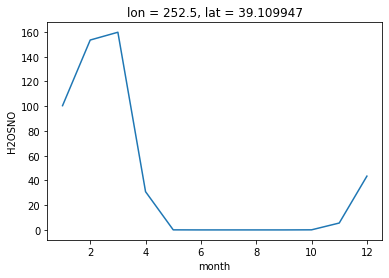

In [15]:
# mask out regions with very little snow or where snow never melts out
minSWE = 30 # mm water
plat, plon, site =  39 , 253  , 'Crested Butte, CO' 

# monthly means, averaged over ensembles
SWEmask = dsMask.H2OSNO.groupby('time.month').mean().mean('ens')
temp = SWEmask.sel(lat = plat, lon = plon, method='nearest').plot()

# count months with SWE > minVal
SWEmask = xr.where(SWEmask>minSWE, 1, 0).sum('month')
print(SWEmask.sel(lat = plat, lon = plon, method='nearest').values)

# Mask out < 3 months or snow covered 
SWEmask = SWEmask.where(SWEmask >=3, 0)  
SWEmask = SWEmask.where(SWEmask <12)
#SWEmask.plot();

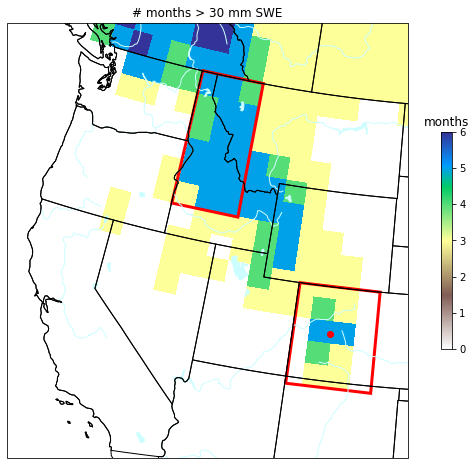

In [16]:
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

#plat2 = [40.0, 39 ]  
#plon2 = [(360-105.4), 253]

conus_proj = ccrs.LambertConformal(central_longitude=-96,central_latitude=39.0)
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1,projection=conus_proj)
ax.set_extent([-123,-104,34,50])
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN, facecolor='#CCFEFF')
ax.add_feature(cfeature.LAKES, facecolor='#CCFEFF')
ax.add_feature(cfeature.LAND, facecolor='#FFE9B5')
ax.add_feature(cfeature.STATES, edgecolor='black', zorder=10)
ax.add_feature(cfeature.RIVERS, edgecolor='#CCFEFF')

# -- draw box around S. Rockies -- 
#104–109°W, 37–41°N
lat_corners = np.array([36.7,  36.7, 41, 41])
lon_corners = np.array([ (360-109), (360-104.5), (360-104.5), (360-109)])

poly_corners = np.zeros((len(lat_corners), 2), np.float64)
poly_corners[:,0] = lon_corners
poly_corners[:,1] = lat_corners

poly = mpatches.Polygon(poly_corners, closed=True, ec='r', fill=False,lw=3, transform=ccrs.Geodetic())
ax.add_patch(poly)

# -- draw box around N. Rockies -- 
lat_corners = np.array([43.3,  43.3, 49, 49])
lon_corners = np.array([ (360-117), (360-113.1), (360-113.1), (360-117)])

poly_corners = np.zeros((len(lat_corners), 2), np.float64)
poly_corners[:,0] = lon_corners
poly_corners[:,1] = lat_corners

poly = mpatches.Polygon(poly_corners, closed=True, ec='r', fill=False,lw=3, transform=ccrs.Geodetic())
ax.add_patch(poly)

# -- filled contours, max snow from single ensemble in first decade ==
cf = ax.pcolormesh(SWEmask.lon, SWEmask.lat, SWEmask, 
                   vmin=0,vmax=6, cmap='terrain_r',
                   transform=ccrs.PlateCarree());
#cf = ax.pcolormesh(dsREG2.lon, dsREG2.lat, dsREG2.H2OSNO.isel(ens=1, time=slice(0,120)).max(dim='time'), 
#                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf, shrink=0.5)
cb.ax.set_title('months')
ax.set_title('# months > '+str(minSWE)+' mm SWE');
plt.plot(plon, plat,
         color='red', linewidth=0, marker='o',
         transform=ccrs.Geodetic(),
         )

plt.show()

#dsREG.H2OSNO.max(dim='time').isel(ens=1).plot(robust=True)
#dsREG = dsREG.mean(dim=['lat','lon'])

In [17]:
SWEmask = SWEmask.persist()
_ = wait(SWEmask) 

## Read in daily data
- 5 ens. members = 164 GB memory, 20 workers @ 40 GB gets 745 GB memory
- 20 ens members = XXX    memory, 50 workers @ 40 GB get 2 TB memory
- full dataset   = 1.6 TB, 90 workers @ 50 GB gets 4TB memory

In [18]:
model = 'CESM2'
ens = 40+np.arange(10)
nens = len(ens)
WaterYear = False

# maybe use SWE (SNOWLIQ) instead of snow depth?
fields = ['H2OSNO','QRUNOFF']
firstyear = 1850
lastyear  = 2100
freq      = 'daily'
ds = get_data(model,ens,fields,firstyear,lastyear,freq)
ds.nbytes/1e9 #GB

405.28237128

#### Get rid of duplicate Jan 1 2015 dates 
- (ntim = 91615, as expected)

/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


CPU times: user 21.5 s, sys: 804 ms, total: 22.3 s
Wall time: 1min 6s


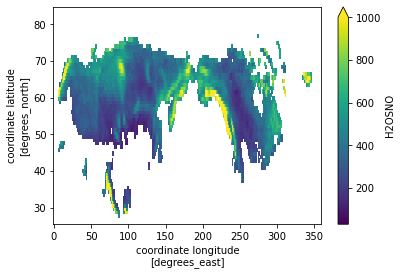

In [19]:
%%time
# we'll just look at 25-80 N for convenience
# mask out regions with very little snow or where snow never melts out
#load smaller dataset into memory
ds = ds.sel(lat=slice(25,85))
ds = ds.sel(time=~ds.get_index("time").duplicated(keep='first') )
ds = ds.where(SWEmask>0).persist()
_ = wait(ds) 
ds.H2OSNO.max(['time','ens']).plot(vmin=minSWE,vmax=1000);

### Quick look to compare melt dynamics with [Musselman et al. 2021](https://www-nature-com.cuucar.idm.oclc.org/articles/s41558-021-01014-9)
- sum snow melt fluxes & winter melt before peak SWE
- start with single point from one ensemble member
- shift to water year to make this easier

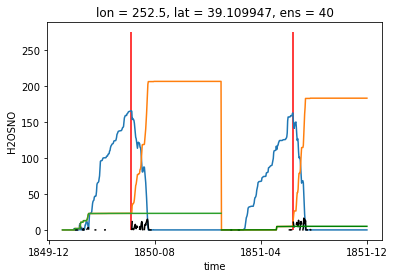

In [20]:
plat, plon, site =  39 , 253  , 'Crested Butte, CO' 
#plat, plon, site = 64.8, 212.4, 'Fairbanks, AK'

temp = ds.sel(lat = plat, lon = plon, method='nearest').isel(ens=0)
temp = temp.shift(time=-273)

# claculate and plot melt (orange) from SWE (blue)
melt = temp.H2OSNO.shift(time=1) - temp.H2OSNO
melt = melt.where(melt>0)
temp.H2OSNO.isel(time=slice(0,700)).plot(x='time');
melt.isel(time=slice(0,700)).groupby('time.year') \
    .apply(lambda c: c.cumsum(dim="time")).plot(x='time')
melt.isel(time=slice(0,700)).plot(x='time', color='k') ;

# calculate and plot max SWE day
SWEmax = temp.H2OSNO.fillna(0).groupby('time.year') \
    .apply(lambda c: c.argmax(dim="time",skipna=True))
maxSWEday = temp.time.isel(time=slice(0,700))[SWEmax[0:2].values+ np.array([0,365])].values

plt.vlines(maxSWEday,0,275,color='r')

# sum melt before peak SWE
melt2 = melt.where(melt.time<maxSWEday[0])
melt2.isel(time=slice(0,365)).groupby('time.year') \
    .apply(lambda c: c.cumsum(dim="time")).plot(x='time')
# This could be done better, but functional for now
melt3 = melt.where(melt.time<maxSWEday[1])
melt3.isel(time=slice(365,700)).groupby('time.year') \
    .apply(lambda c: c.cumsum(dim="time")).plot(x='time',color='g');

### Calculate melt rates
This is easier to do for April melt date BEFORE shifting to water years

In [21]:
## calculate MELT and WinterMELT
ds['MELT'] = ds.H2OSNO.shift(time=1) - ds.H2OSNO
ds['MELT'] = ds['MELT'].where(ds['MELT']>0)
ds['MELT'].attrs['units'] = 'mm/d'
ds['MELT'].attrs['long_name'] = 'daily snow melt'

# melt that occurs before April 1 
#ds['AprilMELT'] = ds.MELT.where((ds['time.dayofyear'] < 91) | (ds['time.dayofyear'] > 273) )
#ds['AprilMELT'].attrs['units'] = 'mm/d'
#ds['AprilMELT'].attrs['long_name'] = 'Snow melt before April 1'

In [22]:
# Create new SWE variable that would not be shifted to water years
ds['SWE'] = ds.H2OSNO.copy(deep=True)
ds.var

<bound method ImplementsDatasetReduce._reduce_method.<locals>.wrapped_func of <xarray.Dataset>
Dimensions:   (ens: 10, lat: 63, lon: 288, time: 91615)
Coordinates:
  * lon       (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat       (lat) float32 25.92 26.86 27.8 28.74 ... 81.52 82.46 83.4 84.35
  * time      (time) object 1850-01-01 00:00:00 ... 2100-12-31 00:00:00
  * ens       (ens) int64 40 41 42 43 44 45 46 47 48 49
Data variables:
    H2OSNO    (ens, time, lat, lon) float32 dask.array<chunksize=(1, 1000, 63, 288), meta=np.ndarray>
    QRUNOFF   (ens, time, lat, lon) float32 dask.array<chunksize=(1, 1000, 63, 288), meta=np.ndarray>
    area      (lat, lon) float32 dask.array<chunksize=(63, 288), meta=np.ndarray>
    landfrac  (lat, lon) float32 dask.array<chunksize=(63, 288), meta=np.ndarray>
    landmask  (lat, lon) float64 dask.array<chunksize=(63, 288), meta=np.ndarray>
    pftmask   (lat, lon) float64 dask.array<chunksize=(63, 288), meta=np.ndarray>
    

### Shift results to water year, **just do this once!**
- `WaterYear` protects against doing this multiple times
- Do this before calculating winter melt before peak SWE

In [23]:
shiftVars = ['MELT','QRUNOFF','H2OSNO']
if WaterYear == False:
    shift = -273  #starts water year Oct 1
    for i in range(len(shiftVars)):
        ds[shiftVars[i]] = ds[shiftVars[i]].shift(time=shift)
    # shift time coords too?
    # Not for this application where we just want to select features of water year
    #ds['time'] = ds.time.shift(time=shift)
    WaterYear=True

----
#### Calculate running mean for QRUNOFF to smooth results
- convert units to mm/d

In [24]:
%%time 
# TODO, changing time chunks may make this more efficient?
s2d = 3600 * 24
ds['QRUNOFF'] = ds.QRUNOFF.chunk({"time": 100}).rolling(time=21, center=True).mean()
ds['QRUNOFF'] = (ds['QRUNOFF'] *s2d).persist()
_ = wait(ds['QRUNOFF'])

# Get chunks for Qrunnoff back to 'normal'
ds['QRUNOFF'] = ds.QRUNOFF.chunk({"time": 1000})
ds['QRUNOFF'].attrs['units'] = 'mm/d'
ds = ds.chunk({"time": 1000})
ds = ds.chunk({"ens": 1})

CPU times: user 1min 26s, sys: 1.65 s, total: 1min 27s
Wall time: 1min 27s


---
### Identify centroid timing, or  center timing (CT), for each water year
- day of year when 50% of runoff has past
- see Stewart et al 2005 https://journals.ametsoc.org/view/journals/clim/18/8/jcli3321.1.xml

1850-07-13 00:00:00


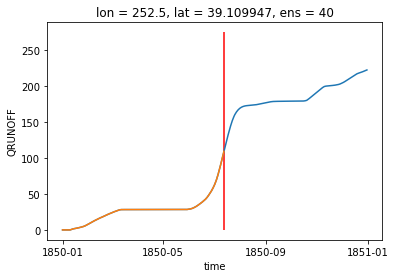

In [25]:
temp = ds.sel(lat = plat, lon = plon, method='nearest').isel(ens=0)
annRUNOFF = temp.QRUNOFF.isel(time=slice(0,365)).cumsum()
annRUNOFF.plot(x='time',hue='ens');
Q50 = annRUNOFF.where(annRUNOFF<annRUNOFF.max()/2)
Q50.plot(x='time',hue='ens'); 
#q50max = temp.H2OSNO.fillna(0).groupby('time.year') \
#    .apply(lambda c: c.argmax(dim="time",skipna=True))
#maxSWEday = temp.time.isel(time=slice(0,700))[SWEmax[0:2].values+ np.array([0,365])].values
CT = Q50.time.where(annRUNOFF<annRUNOFF.max()/2).max().values
plt.vlines(CT,0,275,color='r') ;
print(CT)

In [26]:
%%time
daQRUNOFF = ds.QRUNOFF.to_dataset(
    name="aux_name"
).assign_coords(
    year=np.arange(1850, 2101),doy=np.arange(365), 
).stack(
    aux_dim=("year","doy"),
).reset_index(
    "time", drop=True,
).rename(
    time="aux_dim",
).unstack("aux_dim").aux_name
daQRUNOFF = daQRUNOFF.persist()
_ = wait(daQRUNOFF)

CPU times: user 6.48 s, sys: 234 ms, total: 6.72 s
Wall time: 11 s


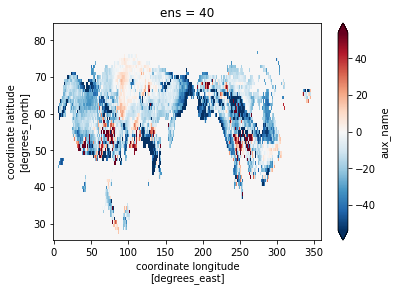

In [27]:
annRUNOFF = daQRUNOFF.cumsum(dim='doy')
Q50 = annRUNOFF.where(annRUNOFF<annRUNOFF.max(dim='doy')/2)
CT  = Q50.fillna(0).groupby('year') \
                   .apply(lambda c: c.argmax(dim="doy",skipna=True))
(CT.isel(ens=0,year=200)-CT.isel(ens=0,year=0)).plot(robust=True) ; 

193


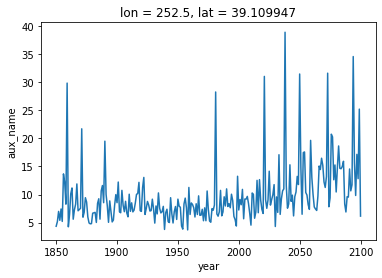

In [28]:
print(CT.sel(lat = plat, lon = plon, method='nearest').isel(ens=0,year=0).values)
CT = CT.persist()
_ = wait(CT)
CT.attrs['long_name'] = 'centroid timing'
CT.attrs['units'] = 'day of water year'
#CT.sel(lat = plat, lon = plon, method='nearest').mean('ens').plot()
CT.sel(lat = plat, lon = plon, method='nearest').std('ens').plot() ;

---
#### Calculate day of max SWE, then used to mask out melt days after peak SWE

In [29]:
%%time
# to avoid overloading memory need to loop through this
for ee in range(nens): 
    print('starting '+str(ee))
    coords = ds.H2OSNO.isel(ens=ee).coords
    doy    = ds.H2OSNO.isel(ens=ee)['time.dayofyear'] 
    SWEmaxDate = ds.H2OSNO.isel(ens=ee).fillna(0).groupby('time.year') \
        .apply(lambda c: c.argmax(dim="time",skipna=True))
    smd      = xr.DataArray(np.tile(SWEmaxDate,[365,1,1]),coords=coords).persist()
    pre_max  = doy<=smd
    temp = pre_max*ds.MELT.isel(ens=ee)

    if ee == 0 : 
        WinterMELT = temp.persist()
    else: 
        WinterMELT = xr.concat([WinterMELT, temp], dim='ens').persist()
        
    _ = wait(WinterMELT) 

starting 0
starting 1
starting 2
starting 3
starting 4
starting 5
starting 6
starting 7
starting 8
starting 9
CPU times: user 2min 17s, sys: 55.8 s, total: 3min 13s
Wall time: 3min 40s


In [30]:
ds['WinterMELT'] = WinterMELT.persist()
_ = wait(ds['WinterMELT'])

ds['WinterMELT'].attrs['units'] = 'mm/d'
ds['WinterMELT'].attrs['long_name'] = 'Snow melt before peak SWE'

### Test plot to see if logic works

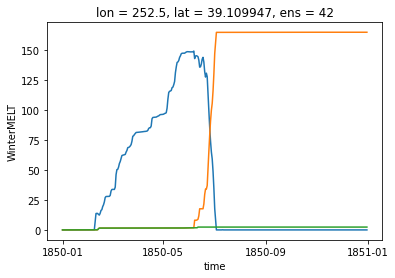

In [31]:
temp = ds.sel(lat = plat, lon = plon, method='nearest').isel(ens=slice(2,3))
temp.H2OSNO.isel(time=slice(0,365)).plot(x='time',hue='ens');
temp.MELT.isel(time=slice(0,365)).cumsum().plot(x='time',hue='ens');
temp.WinterMELT.isel(time=slice(0,365)).cumsum().plot(x='time',hue='ens');

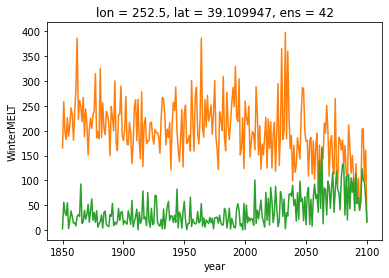

In [32]:
# this is kind of slow...
temp.MELT.groupby('time.year').sum().plot(color='tab:orange')
temp.WinterMELT.groupby('time.year').sum().plot(color='tab:green') ;

----------------
### Characterize snow dynamics & snow free period
- Day of year with snow off, snow on, snow free period & max snow depth
- Day of water year with max runoff, max daily runoff, and total annual runoff


[109 103 107]
[318 322 306]


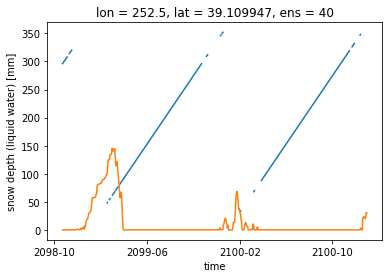

In [33]:
plat, plon, site =  39 , 253  , 'Crested Butte, CO'
#plat, plon, site = 64.8, 212.4, 'Fairbanks, AK'

noSNOW = ds.time.dt.dayofyear.where(ds.SWE==0) \
     .transpose('ens','time','lat','lon')
temp = noSNOW.sel(lat = plat, lon = plon, method='nearest').isel(ens=1)
temp.isel(time=slice(-800,None)).plot()
ds.SWE.sel(lat = plat, lon = plon, method='nearest').isel(ens=0).isel(time=slice(-800,None)).plot()
#ds.QRUNOFF.sel(lat = plat, lon = plon, method='nearest').isel(ens=0).isel(time=slice(-800,None)).plot()

first = temp.where((temp<180) & (temp>30)).resample(time='AS').min('time',skipna=True).astype('int')
last = temp.where(temp>180).resample(time='AS').max('time',skipna=True).astype('int')
print(first.values[1:4])
print(last.values[1:4])
# snow free = first.shift(-1) + last

In [34]:
%%time
ann_coords = ds.H2OSNO.resample(time='AS').max('time').coords
dsANN = xr.Dataset(coords=ann_coords)

## max, SWE, runoff & sum of fluxes 
dsANN['MaxSnow'] = ds.H2OSNO.resample(time='AS').max('time').persist()
dsANN['MaxQrun'] = ds.QRUNOFF.resample(time='AS').max('time').persist()
dsANN['TotQrun'] = ds.QRUNOFF.resample(time='AS').sum('time').persist()
# Snow melt calculations
dsANN['TotMELT'] = ds.MELT.resample(time='AS').sum('time').persist()
dsANN['WinMELT'] = ds.WinterMELT.resample(time='AS').sum('time').persist()
dsANN['f_WinMELT'] = dsANN['WinMELT'] / dsANN['TotMELT'].persist()

dsANN['MaxQrunDate'] = ds.QRUNOFF.fillna(0).groupby('time.year') \
    .apply(lambda c: c.argmax(dim="time",skipna=True)).persist()

_ = wait(dsANN['MaxQrunDate']) #avoid blowing memory
print('-- finished with annual stats -- ')

-- finished with annual stats -- 
CPU times: user 1min 17s, sys: 2.09 s, total: 1min 19s
Wall time: 1min 24s


In [35]:
# Add in CT, calculated above, and transpose coordinates
dsANN['CT'] = CT
dsANN['CT'] = dsANN.CT.transpose('ens','year','lat','lon')

CPU times: user 26.6 s, sys: 852 ms, total: 27.5 s
Wall time: 29.7 s


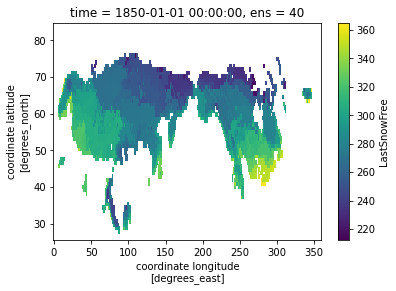

In [36]:
%%time
# Min / max day of year w/o snow, uses SWE, which has not been shifted for water years
# frist snow free must after Jan 30
# last snow free must be after 190 days
# snow free period is Last -first snow free 

noSNOW = ds.time.dt.dayofyear.where(ds.SWE<=0) \
     .transpose('ens','time','lat','lon')
dsANN['FirstSnowFree'] = noSNOW.where((noSNOW<200) & (noSNOW>30)).resample(time='AS') \
    .min('time',skipna=True).astype('int').persist()
dsANN['LastSnowFree'] = noSNOW.where(noSNOW>=200).resample(time='AS') \
    .max('time',skipna=True).astype('int').persist() 
dsANN['FirstSnowFree'] = dsANN.FirstSnowFree.where(dsANN.FirstSnowFree>=0)
dsANN['LastSnowFree'] = dsANN.LastSnowFree.where(dsANN.LastSnowFree>=0)
dsANN['SnowFree'] = (dsANN.LastSnowFree - dsANN.FirstSnowFree).astype('int').persist() 
_ = wait(dsANN['SnowFree']) #avoid blowing memory

dsANN = dsANN.chunk({"ens": 10})
dsANN = dsANN.chunk({"time": 251})

dsANN.LastSnowFree.isel(ens=0,time=0).plot() ;

In [37]:
# add attributes to annual dataset 
sno_vars = ['MaxSnow','LastSnow','FirstSnow',
            'SnowFree','MaxQrun','MaxQrunDate','TotQrun',
            'TotMELT','WinMELT','f_WinMELT']
dsANN.MaxSnow.attrs['long_name'] = 'max annual snow depth'
dsANN.MaxQrun.attrs['long_name'] = 'max runoff by water year'
dsANN.TotQrun.attrs['long_name'] = 'total runoff by water year'
dsANN.TotQrun.attrs['units'] = 'mm y^-1'
dsANN.MaxQrunDate.attrs['long_name'] = 'water year date of max runoff'
dsANN.FirstSnowFree.attrs['long_name'] = 'first snow free day'
dsANN.LastSnowFree.attrs['long_name'] = 'last snow free day'
dsANN.SnowFree.attrs['long_name'] = 'number of snow free days'
dsANN.TotMELT.attrs['long_name'] = 'total snow melt'
dsANN.WinMELT.attrs['long_name'] = 'winter snow melt'
dsANN.f_WinMELT.attrs['long_name'] = 'winter snow melt fraction'
dsANN.coords['time'] = dsANN['year']
dsANN = dsANN.swap_dims({"year": "time"})

#### Mask out regions that initially have 
   - less than 10 cm snow depth & 
   - more than 275 snow free days (min 3 months snow coverage)
   - continually snow covered

In [38]:
dsANN = dsANN.where(dsANN.FirstSnowFree>=0)
#.isel(ens=0,time=-1).plot() ;

#### Write out results to disk

In [39]:
%%time 
pathout = ('/glade/scratch/wwieder/VernalWindow/SnowStatsSWE_ens_'+ \
    str(dsANN.ens.min().values)+'-'+ \
    str(dsANN.ens.max().values)+'.nc')
dsANN.to_netcdf(pathout)
print('wrote '+pathout)

wrote /glade/scratch/wwieder/VernalWindow/SnowStatsSWE_ens_40-49.nc
CPU times: user 18.7 s, sys: 762 ms, total: 19.5 s
Wall time: 1min 23s


--------------
### Play around with ensemble means, stats and time of emergence
- This should be repeated later w/ all ensemble members
--------------


In [40]:
%%time
# ensemble mean of annual data
ds_ensMean = dsANN.mean('ens',skipna=True).compute()
_ = wait(ds_ensMean)

ds_ensStd = dsANN.std('ens',skipna=True).compute()
_ = wait(ds_ensStd)

CPU times: user 19.2 s, sys: 1.25 s, total: 20.4 s
Wall time: 23.7 s


### Length of snow free season & change over time

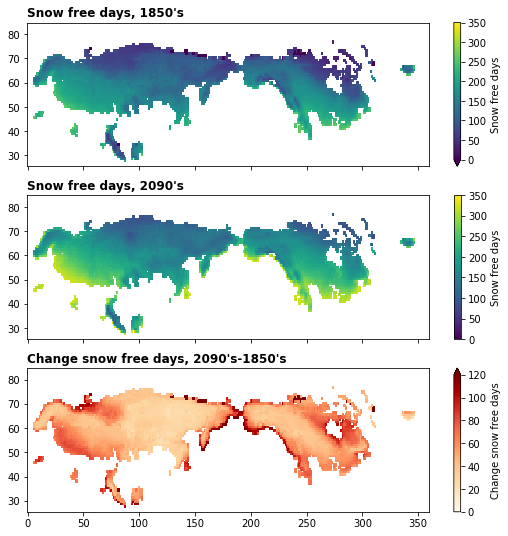

In [43]:
# Number of snow free days
plotVar = 'SnowFree'
f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(9, 9),sharex='col')
# free days 1850's 
ax1.set_title("Snow free days, 1850's",loc='left', fontsize='large', fontweight='bold')
ds_ensMean[plotVar].isel(time=slice(0,10)).mean('time').plot(
    ax=ax1, vmax=350, vmin=0,
    cbar_kwargs={'label': 'Snow free days'}) ;
ax1.set_xlabel('')
ax1.set_ylabel('')

# free days 2100 
ax2.set_title("Snow free days, 2090's",loc='left', fontsize='large', fontweight='bold')
ds_ensMean[plotVar].isel(time=slice(-10,None)).mean('time').plot(
    ax=ax2, vmax=350, vmin=0,
    cbar_kwargs={'label': 'Snow free days'}) ;
ax2.set_xlabel('')
ax2.set_ylabel('')

# Change in snow free days 2100 - 1901
ax3.set_title("Change snow free days, 2090's-1850's",loc='left', fontsize='large', 
              fontweight='bold')
temp = ds_ensMean[plotVar].isel(time=slice(-10,None)).mean('time') - \
       ds_ensMean[plotVar].isel(time=slice(  0,10  )).mean('time')
temp.plot(
    ax=ax3, vmax=120,vmin=0, 
    cbar_kwargs={'label': 'Change snow free days'},cmap='OrRd') 
ax3.set_ylabel('') 
ax3.set_xlabel('') ; 

### max runoff day 

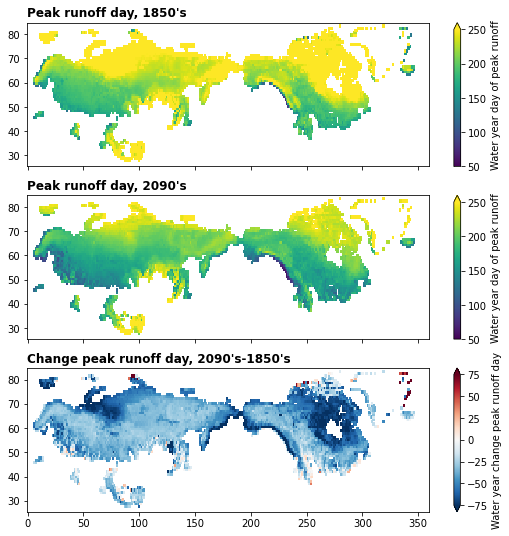

In [36]:
# Day of max runoff
plotVar = 'MaxQrunDate'
f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(9, 9),sharex='col')
# free days 1850's 
ax1.set_title("Peak runoff day, 1850's",loc='left', fontsize='large', fontweight='bold')
ds_ensMean[plotVar].isel(time=slice(0,10)).mean('time').plot(
    ax=ax1, vmax=250, vmin=50,
    cbar_kwargs={'label': 'Water year day of peak runoff'}) ;
ax1.set_xlabel('')
ax1.set_ylabel('')

# free days 2100 
ax2.set_title("Peak runoff day, 2090's",loc='left', fontsize='large', fontweight='bold')
ds_ensMean[plotVar].isel(time=slice(-10,None)).mean('time').plot(
    ax=ax2, vmax=250, vmin=50,
    cbar_kwargs={'label': 'Water year day of peak runoff'}) ;
ax2.set_xlabel('')
ax2.set_ylabel('')

# Change in snow free days 2100 - 1901
ax3.set_title("Change peak runoff day, 2090's-1850's",loc='left', fontsize='large', 
              fontweight='bold')
temp = ds_ensMean[plotVar].isel(time=slice(-10,None)).mean('time') - \
       ds_ensMean[plotVar].isel(time=slice(  0,10  )).mean('time')
temp.plot(
    ax=ax3, vmax=75,vmin=-75, 
    cbar_kwargs={'label': 'Water year change peak runoff day'},cmap='RdBu_r') 
ax3.set_ylabel('') 
ax3.set_xlabel('') ; 

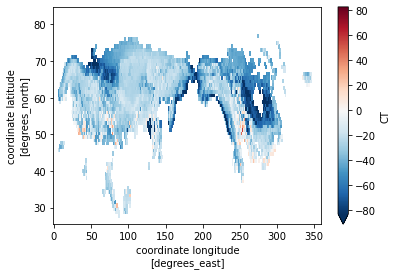

In [49]:
(ds_ensMean.CT.isel(time=slice(-20,None)).mean('time')- \
 ds_ensMean.CT.isel(time=slice(0,20)).mean('time')).plot(robust=True) ;

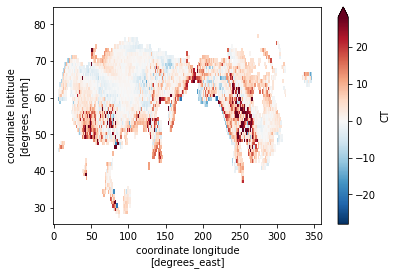

In [50]:
(ds_ensStd.CT.isel(time=slice(-20,None)).mean('time')- \
 ds_ensStd.CT.isel(time=slice(0,20)).mean('time')).plot(robust=True) ;

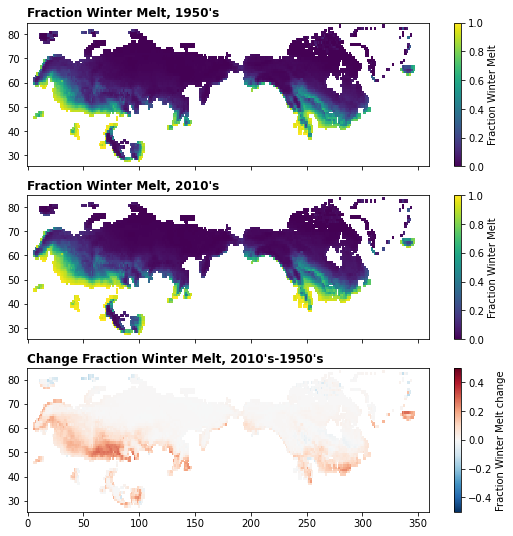

In [42]:
# Day of max runoff
plotVar = 'f_WinMELT'
f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(9, 9),sharex='col')
# free days 1850's 
ax1.set_title("Fraction Winter Melt, 1950's",loc='left', fontsize='large', fontweight='bold')
ds_ensMean[plotVar].isel(time=slice(100,110)).mean('time').plot(
    ax=ax1, vmax=1, vmin=0,
    cbar_kwargs={'label': 'Fraction Winter Melt'}) ;
ax1.set_xlabel('')
ax1.set_ylabel('')

# free days 2100 
ax2.set_title("Fraction Winter Melt, 2010's",loc='left', fontsize='large', fontweight='bold')
ds_ensMean[plotVar].isel(time=slice(150,160)).mean('time').plot(
    ax=ax2, vmax=1, vmin=0,
    cbar_kwargs={'label': 'Fraction Winter Melt'}) ;
ax2.set_xlabel('')
ax2.set_ylabel('')

# Change in snow free days 2100 - 1901
ax3.set_title("Change Fraction Winter Melt, 2010's-1950's",loc='left', fontsize='large', 
              fontweight='bold')
temp = ds_ensMean[plotVar].isel(time=slice(150,160)).mean('time') - \
       ds_ensMean[plotVar].isel(time=slice(100,110)).mean('time')
temp.plot(
    ax=ax3, vmax=0.5, vmin= -0.5, 
    cbar_kwargs={'label': 'Fraction Winter Melt change'},cmap='RdBu_r') 
ax3.set_ylabel('') 
ax3.set_xlabel('') ; 

_Do regions with later runoff days become rain / warm season precip dominanted?_

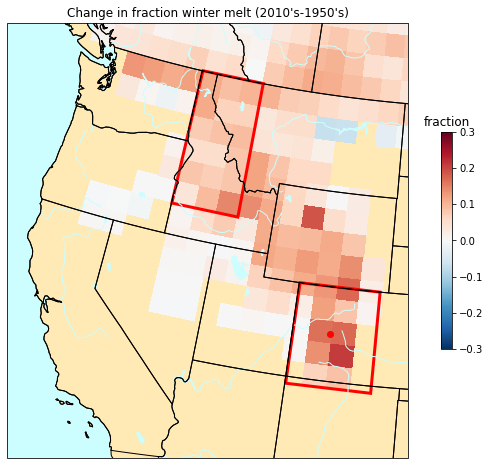

In [46]:
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

#plat2 = [40.0, 39 ]  
#plon2 = [(360-105.4), 253]

conus_proj = ccrs.LambertConformal(central_longitude=-96,central_latitude=39.0)
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1,projection=conus_proj)
ax.set_extent([-123,-104,34,50])
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN, facecolor='#CCFEFF')
ax.add_feature(cfeature.LAKES, facecolor='#CCFEFF')
ax.add_feature(cfeature.LAND, facecolor='#FFE9B5')
ax.add_feature(cfeature.STATES, edgecolor='black', zorder=10)
ax.add_feature(cfeature.RIVERS, edgecolor='#CCFEFF')

# -- draw box around S. Rockies -- 
#104–109°W, 37–41°N
lat_corners = np.array([36.7,  36.7, 41, 41])
lon_corners = np.array([ (360-109), (360-104.5), (360-104.5), (360-109)])

poly_corners = np.zeros((len(lat_corners), 2), np.float64)
poly_corners[:,0] = lon_corners
poly_corners[:,1] = lat_corners

poly = mpatches.Polygon(poly_corners, closed=True, ec='r', fill=False,lw=3, transform=ccrs.Geodetic())
ax.add_patch(poly)

# -- draw box around N. Rockies -- 
lat_corners = np.array([43.3,  43.3, 49, 49])
lon_corners = np.array([ (360-117), (360-113.1), (360-113.1), (360-117)])

poly_corners = np.zeros((len(lat_corners), 2), np.float64)
poly_corners[:,0] = lon_corners
poly_corners[:,1] = lat_corners

poly = mpatches.Polygon(poly_corners, closed=True, ec='r', fill=False,lw=3, transform=ccrs.Geodetic())
ax.add_patch(poly)

# -- filled contours, max snow from single ensemble in first decade ==
cf = ax.pcolormesh(temp.lon, temp.lat, temp, 
                   vmin=-0.3,vmax=0.3, cmap='RdBu_r',
                   transform=ccrs.PlateCarree());
#cf = ax.pcolormesh(dsREG2.lon, dsREG2.lat, dsREG2.H2OSNO.isel(ens=1, time=slice(0,120)).max(dim='time'), 
#                 transform=ccrs.PlateCarree());
cb = plt.colorbar(cf, shrink=0.5)
cb.ax.set_title('fraction')
ax.set_title("Change in fraction winter melt (2010's-1950's)");
plt.plot(plon, plat,
         color='red', linewidth=0, marker='o',
         transform=ccrs.Geodetic(),
         )

plt.show()

#dsREG.H2OSNO.max(dim='time').isel(ens=1).plot(robust=True)
#dsREG = dsREG.mean(dim=['lat','lon'])

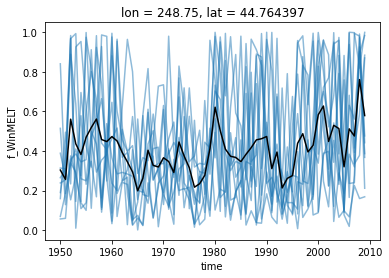

In [58]:
plat = [40.45, 44.66 ,48.5]  
plon = [360-105.75, 360-111.09, 360-113.97]
site = ['Rocky Mountain NP','Yellowstone NP', 'Glacier NP']

dsANN.f_WinMELT.sel(lat = plat[1], lon = plon[1], method='nearest') \
  .isel(time=slice(100,160)) \
  .plot(x='time',hue='ens',color='tab:blue',alpha=0.5,add_legend=False) ;
dsANN.f_WinMELT.sel(lat = plat[1], lon = plon[1], method='nearest').mean(dim='ens') \
  .isel(time=slice(100,160)) \
  .plot(x='time',color='k') ;

### Zoom into regional changes 

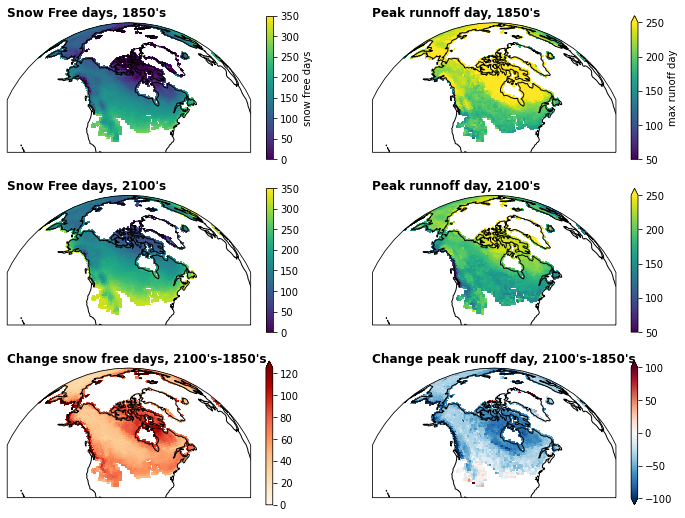

In [28]:
# Number of snow free days
plotVar = ['SnowFree','MaxQrunDate']
#lat,lon,region,ortho = [25,80], [0,360], 'Europe', [80,30]
lat,lon,region,ortho = [35,85], [0,360], 'W. NA',[-100,30]
dsWest =  ds_ensMean.sel(lat=slice(lat[0],lat[1]), lon=slice(lon[0],lon[1]))

f, ((ax1, ax2),(ax3, ax4),(ax5,ax6))= plt.subplots(
    3,2, figsize=(12, 9),sharey='row',sharex='col',
    subplot_kw=dict(projection=ccrs.Orthographic(ortho[0], ortho[1])) )

# free days 1901 
ax1.set_title("Snow Free days, 1850's",loc='left', 
              fontsize='large', fontweight='bold')
dsWest[plotVar[0]].isel(time=slice(0,10)).mean('time').plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),  # this is important!
    vmax=350, vmin=0,cbar_kwargs={'label': 'snow free days'}) ;
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.coastlines()  # cartopy function

ax2.set_title("Peak runnoff day, 1850's",loc='left', 
              fontsize='large', fontweight='bold')
dsWest[plotVar[1]].isel(time=slice(0,10)).mean('time').plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),  # this is important!
    vmax=250, vmin=50,cbar_kwargs={'label': 'max runoff day'}) ;
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.coastlines()  # cartopy function

# free days 2100 
ax3.set_title("Snow Free days, 2100's",loc='left', 
              fontsize='large', fontweight='bold')
dsWest[plotVar[0]].isel(time=slice(-10,None)).mean('time').plot(
    ax=ax3,
    transform=ccrs.PlateCarree(),  # this is important!
    vmax=350, vmin=0,cbar_kwargs={'label': ''}) ;
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.coastlines()  # cartopy function

ax4.set_title("Peak runnoff day, 2100's",loc='left', 
              fontsize='large', fontweight='bold')
dsWest[plotVar[1]].isel(time=slice(-10,None)).mean('time').plot(
    ax=ax4,
    transform=ccrs.PlateCarree(),  # this is important!
    vmax=250, vmin=50,cbar_kwargs={'label': ''}) ;
ax4.set_xlabel('')
ax4.set_ylabel('')
ax4.coastlines()  # cartopy function

# Change  2100 - 1901
ax5.set_title("Change snow free days, 2100's-1850's",loc='left', 
              fontsize='large', fontweight='bold')
(dsWest[plotVar[0]].isel(time=slice(-10,None)).mean('time') - 
 dsWest[plotVar[0]].isel(time=slice(  0,10  )).mean('time')).plot(
    ax=ax5,
    transform=ccrs.PlateCarree(),  # this is important!
    vmax=125,vmin=0, cbar_kwargs={'label': ''},cmap='OrRd') ;
ax5.set_xlabel('')
ax5.set_ylabel('')
ax5.coastlines()  # cartopy function

ax6.set_title("Change peak runoff day, 2100's-1850's",loc='left', 
              fontsize='large', fontweight='bold')
(dsWest[plotVar[1]].isel(time=slice(-10,None)).mean('time') - 
 dsWest[plotVar[1]].isel(time=slice(  0,  10)).mean('time')).plot(
    ax=ax6,
    transform=ccrs.PlateCarree(),  # this is important!
    vmax=100,vmin=-100, cbar_kwargs={'label': ''},cmap='RdBu_r') ;
ax6.set_xlabel('')
ax6.set_ylabel('')  
ax6.coastlines() ;  # cartopy function

### Start by looking at a single gridcell

In [29]:
# select grid of interest
plat, plon, site =  39 , 253  , 'Crested Butte, CO' 
#plat, plon, site = 64.8, 212.4, 'Fairbanks, AK'

dsPT = ds.sel(lat = plat, lon = plon, method='nearest')
dsPTANN = dsANN.sel(lat = plat, lon = plon, method='nearest')

CPU times: user 451 ms, sys: 8.41 ms, total: 459 ms
Wall time: 1.22 s


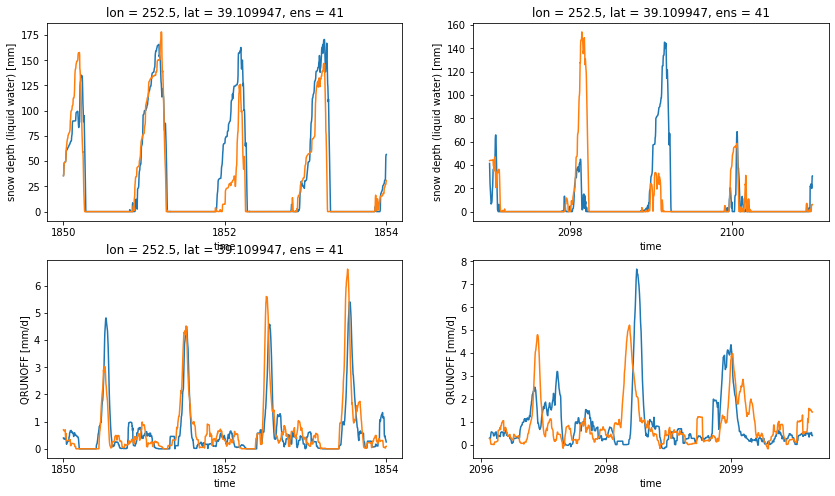

In [30]:
%%time 
# look at first ~5 years of data 

plt.figure(figsize=[14,8])
p = 0
for i in range(len(fields)):
    p = p+1
    plt.subplot(2,2,p)
    dsPT[fields[i]].isel(time=slice(0,(365*4)), ens=0).plot(x='time') ;
    dsPT[fields[i]].isel(time=slice(0,(365*4)), ens=1).plot(x='time') ;

    p = p+1
    plt.subplot(2,2,p)
    dsPT[fields[i]].isel(time=slice((-365*4),-1), ens=0).plot(x='time') ;
    dsPT[fields[i]].isel(time=slice((-365*4),-1), ens=1).plot(x='time') ;
    if i >0: 
        plt.title(" ") ;

#### Look at changes in snow depth & vernal window, single site

In [31]:
pltSinglePT = False
# Plotting raw daily data takes forever... may skip this?
if pltSinglePT == True:
    plt.figure(figsize=[14,10])
    for i in range(len(sno_vars)):
        plt.subplot(4,2,(i+1))
        dsPTANN[sno_vars[i]].isel(ens=slice(0,5)).plot(hue='ens',add_legend=False)  
        plt.title(" ") ;
        if i == 0: plt.title(site+': lat = '+str(plat)+' lon = '+str(plon), 
                             loc='left', fontsize='large', fontweight='bold') 
    

<Figure size 1008x792 with 0 Axes>

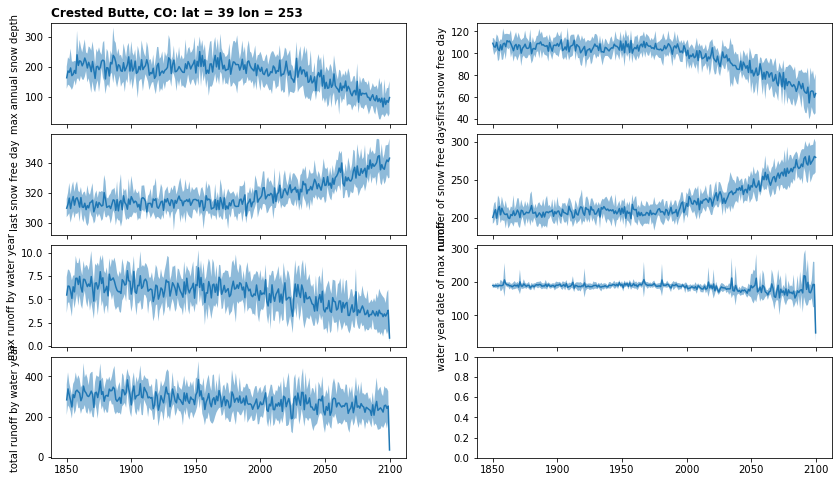

In [32]:
plt.figure(figsize=[14,11])
fig, axs = plt.subplots(4,2, sharex=True,
                        gridspec_kw={'wspace': 0.2, 'hspace': 0.1},
                        figsize=(14,8))
i,j = 0,0
for v in range(len(sno_vars)):
    x = ds_ensMean.time
    y = ds_ensMean[sno_vars[v]].sel(lat = plat, lon = plon, method='nearest')
    y2 = ds_ensStd[sno_vars[v]].sel(lat = plat, lon = plon, method='nearest')
        
    axs[i,j].plot(x, y, '-')
    axs[i,j].fill_between(x, y - y2, y + y2, alpha=0.5)
    axs[i,j].set_ylabel(dsANN[sno_vars[v]].attrs['long_name']) ;
    if v == 0: 
        axs[i,j].set_title(site+': lat = '+str(plat)+' lon = '+str(plon), 
                           loc='left', fontsize='large', fontweight='bold') 
    # move counter for panel
    j = j+1
    if j == 2:
        i = i+1
        j = 0

Work computing time of emergce for chagnes in the 'vernal window', 
- below dive into changes in snow and soil temperature over time

## Flavio defined ToE as time when 10 year running mean > baseline
#### Here we'll take: 
- 30 year baseline (1850-1880)
- 10 year running mean

In [33]:
%%time 
# ensemble mean and std over first 30 years
dsBase    = dsANN.isel(time=slice(0,30)).mean(dim=['time','ens']).compute()
dsBaseStd = dsANN.isel(time=slice(0,30)).std(dim=['time','ens']).compute()
#print(dsBase)

/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


CPU times: user 508 ms, sys: 121 ms, total: 629 ms
Wall time: 589 ms


/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


### TODO
- do you take ensemble mean over years, and then 10 year rolling mean?
- here take rolling mean of each ensemble, then take ensemble statistics.

In [34]:
%%time 
#roll_ensMean = ds_ensMean.chunk({"time": 201}).rolling(time=11, center=True).mean(dim='time')
ds_roll = dsANN.chunk({"time": 251}).rolling(time=11, center=True).mean().compute()
# Then take mean and std over rolling mean
roll_ensMean = ds_roll.mean('ens').compute()
roll_ensStd  = ds_roll.std('ens').compute()

CPU times: user 8.65 s, sys: 8.17 s, total: 16.8 s
Wall time: 18.8 s


#### Plot: 
* ensemble mean & standard deviation
* rolling mean & rolling std
* base mean and std (all ensembles over first 20 years)

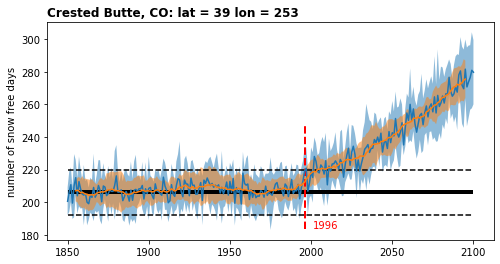

In [35]:
plat, plon, site =  39 , 253  , 'Crested Butte, CO'
#plat, plon, site = 64.8, 212.4, 'Fairbanks, AK'

plt.figure(figsize=[8,4])
x = ds_ensMean.time
y = ds_ensMean['SnowFree'].sel(lat = plat, lon = plon, method='nearest')
y2 = ds_ensStd['SnowFree'].sel(lat = plat, lon = plon, method='nearest')
        
plt.plot(x, y, '-')
plt.fill_between(x, y - y2, y + y2, alpha=0.5)
plt.ylabel(dsANN['SnowFree'].attrs['long_name']) ;

x = roll_ensMean.time
y = roll_ensMean.SnowFree.sel(lat = plat, lon = plon, method='nearest')
y2= roll_ensStd.SnowFree.sel(lat = plat, lon = plon, method='nearest')
plt.plot(x, y)
plt.fill_between(x, y - 2*y2, y + 2*y2, alpha=0.5)

plt.hlines(dsBase.SnowFree.sel(lat = plat, lon = plon, method='nearest'), 1850, 2100, colors='k',lw=4) ;
plt.hlines((dsBase.SnowFree + dsBaseStd.SnowFree).sel(lat = plat, lon = plon, method='nearest'),
           1850, 2100, colors='k',linestyles='dashed') ;
plt.hlines((dsBase.SnowFree - dsBaseStd.SnowFree).sel(lat = plat, lon = plon, method='nearest'),
           1850, 2100, colors='k',linestyles='dashed') 
plt.title(site+': lat = '+str(plat)+' lon = '+str(plon), 
                           loc='left', fontsize='large', fontweight='bold') ;

# find last day when roll mean - 2 std < baseline
test = y - 2*y2
test = test.where(test<dsBase.SnowFree.sel(lat = plat, lon = plon, method='nearest')).dropna('time')
ToE = test.time.isel(time=-1)
plt.vlines(ToE, test.min()*0.95,test.max()*1.2,colors='r',lw=2,linestyles='dashed') ;
plt.text(ToE+5, test.min()*0.95, ToE.values,color='r') ;

#### Test code for all variables

<Figure size 1008x792 with 0 Axes>

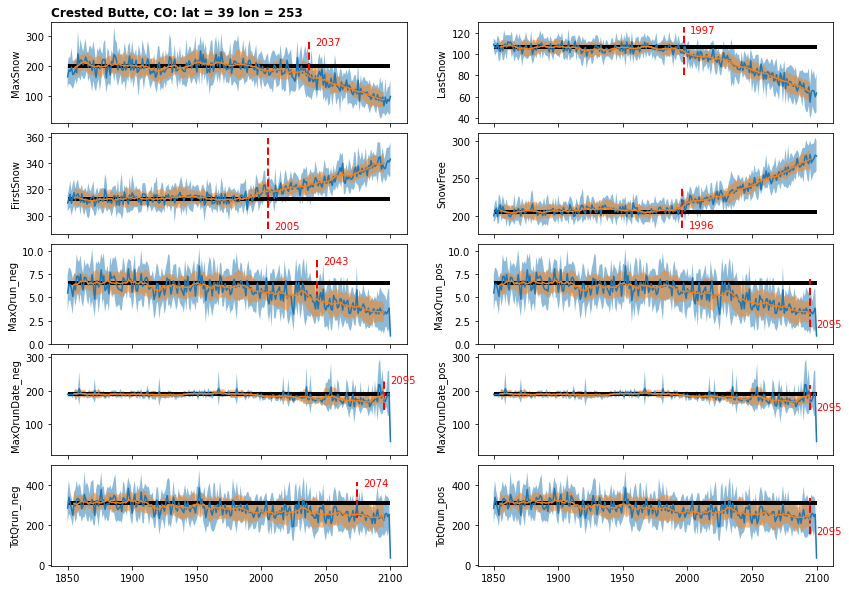

In [36]:
plat, plon, site =  39 , 253  , 'Crested Butte, CO' 
#plat, plon, site = 64.8, 212.4, 'Fairbanks, AK'
#plat, plon, site =  64 , 12.1  , 'Random point' 

in_vars = ['MaxSnow','LastSnow','FirstSnow','SnowFree',
           'MaxQrun','MaxQrun',
           'MaxQrunDate','MaxQrunDate',
           'TotQrun','TotQrun']
sno_vars = ['MaxSnow','LastSnow','FirstSnow','SnowFree',
            'MaxQrun_neg','MaxQrun_pos',
            'MaxQrunDate_neg','MaxQrunDate_pos',
            'TotQrun_neg','TotQrun_pos']
sno_trend = ['neg','neg',
             'pos','pos',
             'neg','pos',
             'neg','pos',
             'neg','pos']
plt.figure(figsize=[14,11])
fig, axs = plt.subplots(5,2, sharex=True,
                        gridspec_kw={'wspace': 0.2, 'hspace': 0.1},
                        figsize=(14,10))
i,j = 0,0
for v in range(len(sno_vars)):
    # ens mean
    x = ds_ensMean.time
    y = ds_ensMean[in_vars[v]].sel(lat = plat, lon = plon, method='nearest')
    y2 = ds_ensStd[in_vars[v]].sel(lat = plat, lon = plon, method='nearest')

    axs[i,j].plot(x, y, '-')
    axs[i,j].fill_between(x, y - y2, y + y2, alpha=0.5)
    axs[i,j].set_ylabel(sno_vars[v]) ;

    # rolling ensemble mean
    x = roll_ensMean.time
    y = roll_ensMean[in_vars[v]].sel(lat = plat, lon = plon, method='nearest')
    y2= roll_ensStd[in_vars[v]].sel(lat = plat, lon = plon, method='nearest')
    axs[i,j].plot(x, y)
    axs[i,j].fill_between(x, y - 2*y2, y + 2*y2, alpha=0.5)

    # baseline
    axs[i,j].hlines(dsBase[in_vars[v]].sel(
        lat = plat, lon = plon, method='nearest'), 
                    1850, 2100, colors='k',lw=4) ;

    # find last day when roll mean - 2 std < baseline
    if sno_trend[v] == 'pos':  # variables w/ positive trend:
        test = y - 2*y2
        test = test.where(test<dsBase[in_vars[v]].sel(
            lat = plat, lon = plon, method='nearest')).dropna('time')
    else:
        test = y + 2*y2
        test = test.where(test>dsBase[in_vars[v]].sel(
            lat = plat, lon = plon, method='nearest')).dropna('time')

    ToE = test.time.isel(time=-1)

    if sno_trend[v] == 'pos': 
        axs[i,j].vlines(ToE, test.min()*0.95,test.max()*1.15,colors='r',
                        lw=2,linestyles='dashed') ;
        axs[i,j].text(ToE+5, test.min()*0.95, ToE.values,color='r')
    else: 
        axs[i,j].vlines(ToE, test.min()*0.75,test.max()*1.1,colors='r',
                        lw=2,linestyles='dashed') ;
        axs[i,j].text(ToE+5, test.max()*1.05, ToE.values,color='r')
    if v == 0: 
        axs[i,j].set_title(site+': lat = '+str(plat)+' lon = '+str(plon), 
                           loc='left', fontsize='large', fontweight='bold') ;
    # move counter for panel
    j = j+1
    if j == 2:
        i = i+1
        j = 0 ;

#### Time of emergence globally

<xarray.DataArray 'time' ()>
array(1996)
Coordinates:
    lon      float32 252.5
    lat      float32 39.11


<xarray.DataArray 'time' ()>
array(2100)

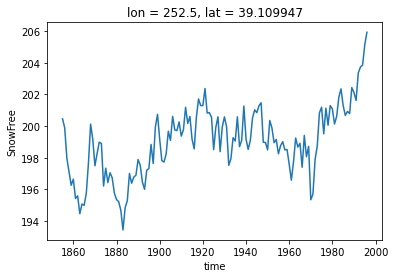

In [37]:
import cartopy.crs as ccrs
# find ToE for Snow free days when roll mean - 2 std < baseline
test = roll_ensMean.SnowFree - 2*roll_ensStd.SnowFree
test = test.where(test<dsBase.SnowFree)
GOI = (test.sel(lat = plat, lon = plon, method='nearest')).dropna('time')
print(GOI.time.max())#isel(time=-1))
GOI.plot()

test.time.max()#.groupby()['time'].max()
#test.time.dropna('time').plot()
#test = test.idxmax(dim='time')
#test.where(test>1850).sel(lon=slice(5,44),lat=slice(50,77)).plot(    
    #transform=ccrs.PlateCarree(),  # remember to provide this!
    #subplot_kws={
    #    "projection": ccrs.LambertConformal(
    #        central_longitude=0, central_latitude=60
    #    )
    #},
#    robust=True) ;
#print(test)

<xarray.DataArray 'time' (lat: 63, lon: 288)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 25.92 26.86 27.8 28.74 ... 81.52 82.46 83.4 84.35


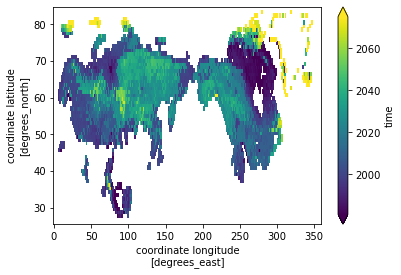

In [38]:
ToE_coords = test.coords
ToE = xr.Dataset(coords=ToE_coords)

for v in range(len(sno_vars)):
    if sno_trend[v] == 'pos':  # variables w/ positive trend:
        temp = roll_ensMean[in_vars[v]] - 2*roll_ensStd[in_vars[v]]
        temp = temp.time.where(temp<dsBase[in_vars[v]])
    else:
        temp = roll_ensMean[in_vars[v]] + 2*roll_ensStd[in_vars[v]]
        temp = temp.time.where(temp>dsBase[in_vars[v]])
    
    if v == 3:
        print(temp.max(dim='time'))
        temp.max(dim='time').plot(robust=True)
    ToE[sno_vars[v]] = temp.max(dim='time')

    ToE = ToE.where(ToE>1850)

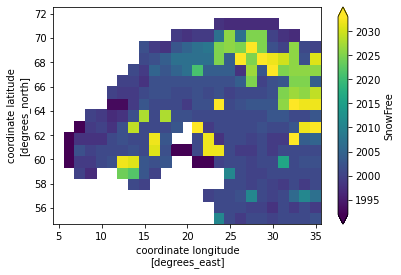

In [39]:
ToE.SnowFree.sel(lon=slice(5,35),lat=slice(55,73)).plot(robust=True) ;

In [40]:
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

# Generate a function for making panel plots of maps
def map_function(da, cb=0, panel=None, cmap=None, ax=None, 
                 title=None, vmax=None, vmin=None):
    '''a function to make one subplot'''
    wrap_data, wrap_lon = add_cyclic_point(da.values, coord=da.lon)

    if ax is None: ax = plt.gca()
    im = ax.pcolormesh(wrap_lon,da.lat,wrap_data,
                   transform=ccrs.PlateCarree(),
                   vmax=vmax,vmin=vmin,cmap=cmap)
    ax.set_title(title)
    ax.coastlines()
    ax.set_extent([-180,180,25,85], crs=ccrs.PlateCarree())
    ax.annotate(panel, xy=(0.05, 0.95), xycoords=ax.transAxes,
                ha='center', va='center',fontsize=16)    

    # allows for different colorbars on each plot
    if cb == 1:
        fig.colorbar(im, ax=ax,pad=0.05, fraction = 0.1, orientation='horizontal')

/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


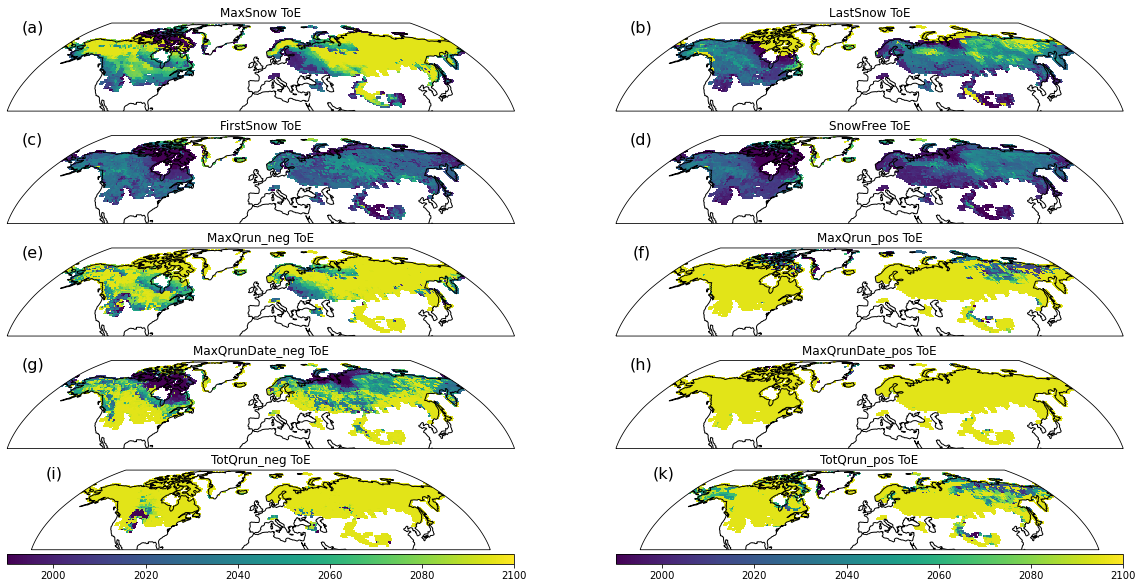

In [41]:
# Now call the map_function
#---------------------
panel = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)',
         '(h)','(i)','(k)','(l)','(m)','(n)']  

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20,10), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
cb = [0,0,0,0,0,0,0,0,1,1]
i = 0
for index, ax in np.ndenumerate(axes):
    #i = index[0]
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    da = ToE[sno_vars[i]]
    map_function(da, panel=panel[i], ax=ax, title=sno_vars[i]+' ToE', 
                 vmin=1990, vmax=2100, cb=cb[i])

    i = i+1

# or to provide a common color bar, set vmax/min so same values and 
#fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5);
#plt.savefig('/glade/scratch/wwieder/svd/'+model+'/'+model+'_Fig_3c_GPP_DTcorr.eps')


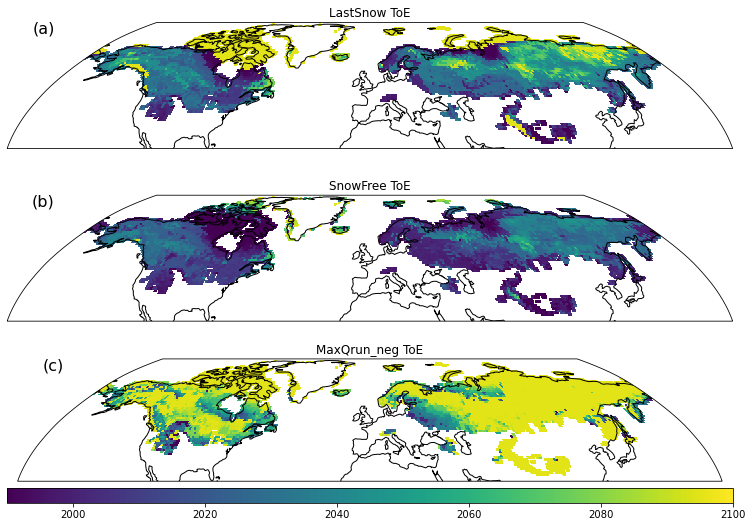

In [42]:
pltVars = ['LastSnow','SnowFree','MaxQrun_neg']
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(13,9), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
cb = [0,0,1]
i = 0
for index, ax in np.ndenumerate(axes):
    #i = index[0]
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    map_function(ToE[pltVars[i]], panel=panel[i], ax=ax, title= pltVars[i]+' ToE', 
                 cb=cb[i], vmin=1990, vmax=2100) 

    i = i+1



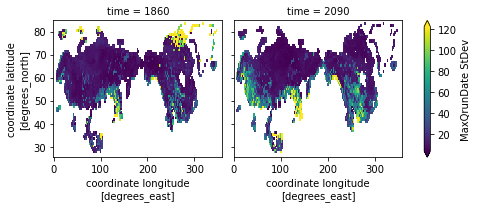

In [43]:
plotVar = 'MaxQrunDate'
ds_ensStd[plotVar].isel(time=[10,-11]).plot(y='lat',x='lon',col="time",
                                            col_wrap=2, robust=True,
                                            cbar_kwargs={"label": plotVar+" StDev",
                                            "pad": 0.05 }  # passed to plt.colorbar
                                           ) ;

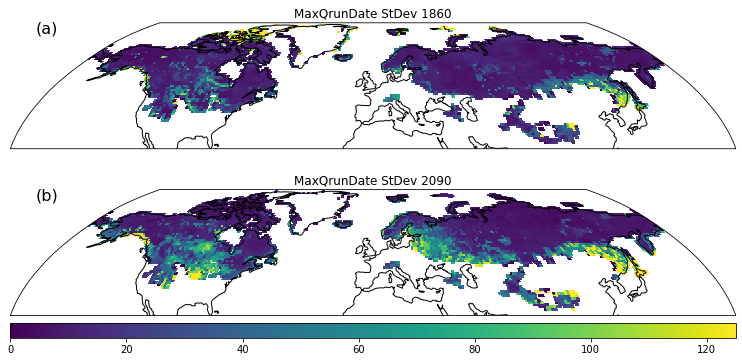

In [44]:
plotVar = 'MaxQrunDate'
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13,6), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
cb = [0,1]
timePlot= [10,-11]
i = 0
for index, ax in np.ndenumerate(axes):
    #i = index[0]
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    year = str(ds_ensStd.time.isel(time=10).values)
    map_function(ds_ensStd[plotVar].isel(time=timePlot[i]), 
                 panel=panel[i], ax=ax, 
                 title= plotVar + ' StDev ' +
                        str(ds_ensStd.time.isel(time=timePlot[i]).values), 
                 cb=cb[i], vmin=0, vmax=125) 

    i = i+1

--------------
### Close cluster

In [51]:
cluster.close()

In [52]:
# https://github.com/rasbt/watermark
%load_ext watermark
%watermark --updated --date --iversions --gitrepo --gitbranch --githash --python

Last updated: 2021-05-17

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.21.0

Git hash: 5fe5aa3c1e3d5fcc6190e7aa9830d7a091da527e

Git repo: https://github.com/wwieder/cesm-lens.git

Git branch: main

numba     : 0.52.0
matplotlib: 3.3.4
cartopy   : 0.18.0
dask      : 2021.2.0
numpy     : 1.20.1
pandas    : 1.2.3
cftime    : 1.4.1
scipy     : 1.6.0
xarray    : 0.17.0



distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
